In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner
import dill, os
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS

In [2]:
# requires https://github.com/kemasuda/jkepler
from jkepler.kepler import xyzrv_from_elements as xyzv

In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='sans-serif')
plt.rcParams["figure.figsize"] = (18,6)
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline

In [4]:
year = np.sqrt(4*np.pi**2*1.495978707e11**3/1.32712440018e20)/86400.

In [5]:
def model(t, sep, e_sep, pa, e_pa, trv, rv, e_rv, p_guess, tau_epoch, tdense, emax=0.9):
    medsep = jnp.median(sep)
    lna = numpyro.sample("lna", dist.Uniform(jnp.log(medsep/5), jnp.log(medsep*5)))
    a = jnp.exp(lna)
    cosi = numpyro.sample("cosi", dist.Uniform(-1, 1))
    ecc = numpyro.sample("ecc", dist.Uniform(0, emax))

    cosw = numpyro.sample("cosw", dist.Normal())
    sinw = numpyro.sample("sinw", dist.Normal())
    omega = jnp.arctan2(sinw, cosw)

    cosL = numpyro.sample("cosL", dist.Normal())
    sinL = numpyro.sample("sinL", dist.Normal())
    lnode = jnp.arctan2(sinL, cosL)

    numpyro.deterministic("a", a)
    numpyro.deterministic("omega", omega*180./jnp.pi)
    numpyro.deterministic("Omega", lnode*180./jnp.pi)
    numpyro.deterministic("inc", jnp.arccos(cosi)*180./jnp.pi)

    lnp = numpyro.sample("lnp", dist.Uniform(np.log(p_guess/2.), np.log(2*p_guess)))
    period = jnp.exp(lnp)

    costau = numpyro.sample("costau", dist.Normal())
    sintau = numpyro.sample("sintau", dist.Normal())
    tau_frac = jnp.arctan2(sintau, costau) / 2. / jnp.pi + 0.5 # -0.5 to 0.5 w/ periodic boundaries
    tau = tau_epoch + tau_frac * period

    numpyro.deterministic("period", period)
    numpyro.deterministic("tau", tau_frac) # time of periastron passage = tau_epoch + tau * period

    numpyro.deterministic("T0", tau)
    numpyro.deterministic("pyear", period/year)

    # +x: +Dec, +y: +RA
    x, y, _, _ = xyzv(t, period, ecc, jnp.arccos(cosi), omega, lnode, tau)
    xmodel = a * x
    ymodel = a * y
    numpyro.deterministic("x_model", xmodel)
    numpyro.deterministic("y_model", ymodel)

    lnjit = numpyro.sample("lnjit", dist.Uniform(low=-5, high=3))
    jit2 = jnp.exp(lnjit*2)
    numpyro.deterministic("jit", jnp.sqrt(jit2))

    # model on dense time array; just to make a plot look nicer (should use predictive)
    xd, yd, _, _ = xyzv(tdense, period, ecc, jnp.arccos(cosi), omega, lnode, tau)
    numpyro.deterministic("xd_model", xd*a)
    numpyro.deterministic("yd_model", yd*a)

    # predicted position at tpred
    xp, yp, _, _ = xyzv(tpred, period, ecc, jnp.arccos(cosi), omega, lnode, tau)
    xp, yp = xp*a, yp*a
    numpyro.deterministic("xpred", xp)
    numpyro.deterministic("ypred", yp)
    numpyro.deterministic("seppred", jnp.sqrt(xp*xp+yp*yp))
    numpyro.deterministic("papred", jnp.arctan2(yp, xp)*180/jnp.pi)

    x = sep * jnp.cos(pa)
    y = sep * jnp.sin(pa)
    x_res = x - xmodel
    y_res = y - ymodel
    sigma2 = jit2 + e_sep**2
    lnsigma2 = jnp.log(sigma2)
    loglikelihood = -0.5*jnp.sum(x_res**2/sigma2 + lnsigma2) - 0.5*jnp.sum(y_res**2/sigma2 + lnsigma2)
    #numpyro.factor("loglike", loglikelihood)

    # RV
    _, _, _, vz = xyzv(trv, period, ecc, jnp.arccos(cosi), omega, lnode, tau)
    logK = numpyro.sample("logK", dist.Uniform(-5, 5))
    K = 10**logK
    numpyro.deterministic("K", K)
    gamma = numpyro.sample("gamma", dist.Uniform(low=-30, high=30))
    lnrvjit = numpyro.sample("lnrvjit", dist.Uniform(low=-7, high=3))
    rvjit = jnp.exp(lnrvjit)
    numpyro.deterministic("rvjit", rvjit)
    rvmodel_base = K * vz
    rvmodel = rvmodel_base + gamma
    res = rv - rvmodel
    numpyro.deterministic("rvmodel", rvmodel)
    numpyro.deterministic("rvmodel_base", rvmodel_base)
    rvsigma2 = rvjit**2 + e_rv**2
    lnrvsigma2 = jnp.log(rvsigma2)
    loglikelihood += -0.5 * jnp.sum(res**2/rvsigma2 + lnrvsigma2)

    numpyro.factor("loglike", loglikelihood)

In [6]:
#%% prior info
targname = 'hr7672'
p_guess = 86.0 * year     # period (yr)
tau_epoch = 25599.5       # reference epoch to measure (fractional) time of periastron passage

#%% for sep/PA prediction
tpred = 2459385.77118 - 2400000.5 # June 20 2021 in MJD

In [7]:
# astrometry data
datafile = 'data/hr7672_astrometry.txt'
data = pd.read_csv(datafile)
data['MJD'] = data.JD - 2400000.5

In [8]:
# RV data
rvdata = pd.read_csv('data/hr7672_rv.tsv', delimiter='|', comment='#')
rvdata['MJD'] = rvdata.BJD - 2400000.5
rvdata['rv'] = rvdata.RV * 1e-3
rvdata['e_rv'] = rvdata.e_RV * 1e-3

In [9]:
mjd, sep, e_sep, pa, e_pa = np.array(data[["MJD", "Sep", "e_Sep", "PA", "e_PA"]]).T
mjdrv, rv, e_rv = np.array(rvdata[["MJD", "rv", "e_rv"]]).T
pa *= np.pi/180.
e_pa *= np.pi/180.
tdense = np.arange(mjd[0]-50, mjd[-1]+50, 20) # dense time grid to make the prediction plot look nicer

In [36]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.90)

In [37]:
n_wm = 10000
n_sample = 20000

In [38]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=n_wm, num_samples=n_sample)

In [39]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, mjd, sep, e_sep, pa, e_pa, mjdrv, rv, e_rv, p_guess, tau_epoch, tdense, extra_fields=('potential_energy',))

sample: 100%|█████████████████████████████████████████| 30000/30000 [30:01<00:00, 16.66it/s, 1023 steps of size 8.75e-04. acc. prob=0.92]


In [40]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      cosL      1.08      0.57      1.02      0.19      1.92    481.82      1.00
      cosi     -0.13      0.01     -0.13     -0.14     -0.11    700.08      1.00
    costau     -1.13      0.57     -1.04     -2.01     -0.31    626.68      1.00
      cosw     -0.25      0.14     -0.22     -0.45     -0.03    349.49      1.00
       ecc      0.53      0.01      0.53      0.51      0.55    229.44      1.00
     gamma      0.58      0.01      0.58      0.57      0.60    273.39      1.00
       lna      6.98      0.03      6.98      6.93      7.04    208.84      1.00
     lnjit     -1.09      1.93     -0.66     -4.27      1.56    992.93      1.00
       lnp     10.29      0.05     10.28     10.20     10.37    209.70      1.00
   lnrvjit     -5.15      0.06     -5.15     -5.24     -5.05   1126.49      1.00
      logK     -0.27      0.00     -0.27     -0.28     -0.26    394.84      1.00
      sinL     -0.61      0

In [41]:
keys = ["pyear", "a", "ecc", "inc", "omega", "Omega", "tau", "lnjit", "K", "gamma", "lnrvjit"]
labels = ["$P$ $(\mathrm{yr})$", "$a$ $(\mathrm{mas})$", "$e$", "$i$ $(\mathrm{deg})$", "$\omega$ $(\mathrm{deg})$", "$\Omega$ $(\mathrm{deg})$", r"$\tau$", "$\ln \sigma$ $(\mathrm{mas})$",  "$K$ (km/s)", "$\gamma$ (km/s)", "$\ln\sigma_\mathrm{RV}$ (km/s)"]

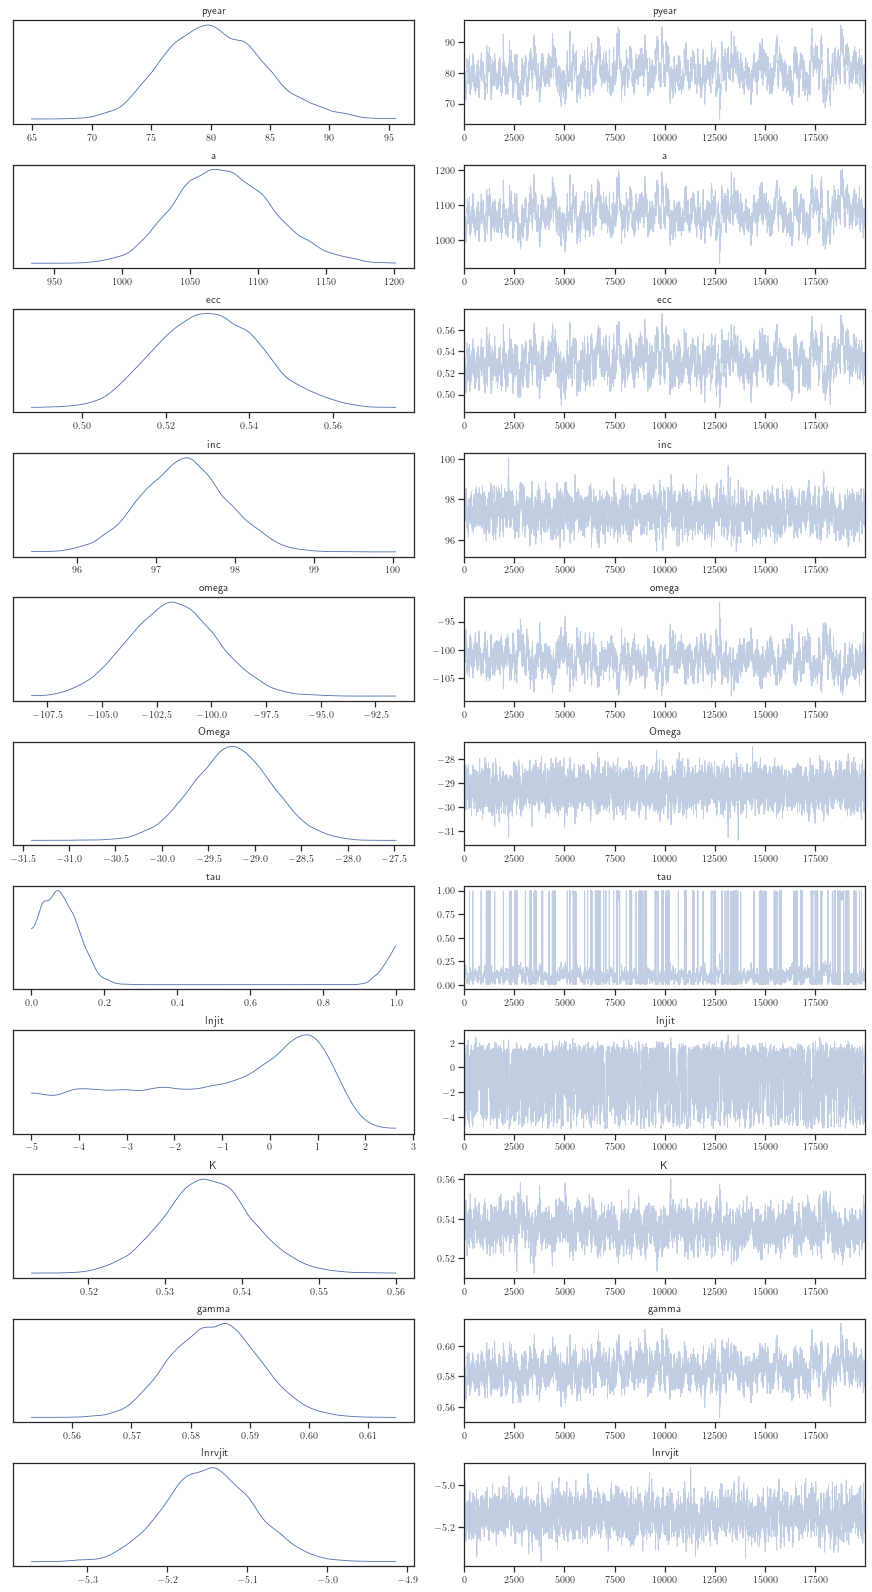

In [43]:
import arviz
fig = arviz.plot_trace(mcmc, var_names=keys, divergences=None)

In [44]:
s = mcmc.get_samples()

In [45]:
xobs, yobs = sep*np.cos(pa), sep*np.sin(pa)
xmean = jnp.mean(s['x_model'], axis=0)
ymean = jnp.mean(s['y_model'], axis=0)
xdmean = jnp.mean(s['xd_model'], axis=0)
ydmean = jnp.mean(s['yd_model'], axis=0)
xdstd = jnp.std(s['xd_model'], axis=0)
ydstd = jnp.std(s['yd_model'], axis=0)
xyerr = jnp.sqrt(jnp.mean(s['jit'])**2 + e_sep**2)
rvmean = jnp.mean(s['rvmodel'], axis=0)
rvstd = jnp.std(s['rvmodel'], axis=0)
rverr = jnp.sqrt(jnp.mean(s['rvjit'])**2 + e_rv**2)

In [46]:
basename = targname + "_test"

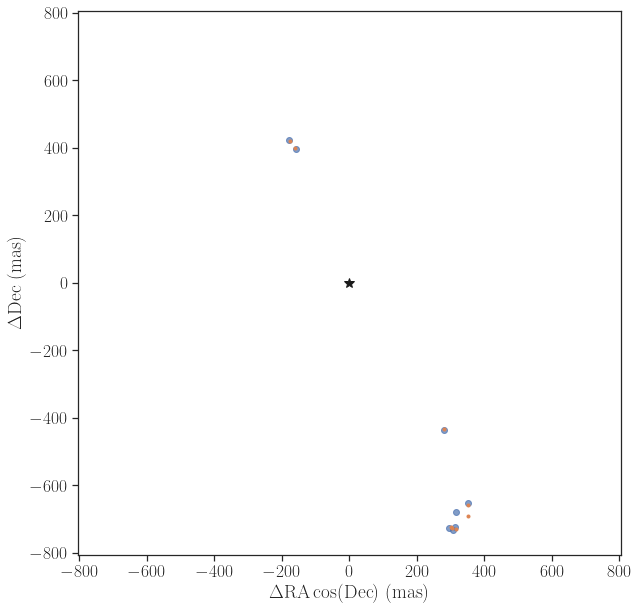

In [47]:
xymax = max(np.max(np.abs(xobs)), np.max(np.abs(yobs)))*1.1
plt.figure(figsize=(10,10))
plt.axes().set_aspect('equal')
plt.xlim(-xymax, xymax)
plt.ylim(-xymax, xymax)
plt.xlabel("$\Delta\mathrm{RA}\cos(\mathrm{Dec})$ $(\mathrm{mas})$")
plt.ylabel("$\Delta\mathrm{Dec}$ $(\mathrm{mas})$")
plt.plot([0], [0], '*', color='k', markersize=10)
plt.plot(yobs, xobs, 'o', label='data', alpha=0.7)
plt.plot(ymean, xmean, '.', label='mean model')
plt.savefig(basename+"_sky.png", dpi=200, bbox_inches="tight")

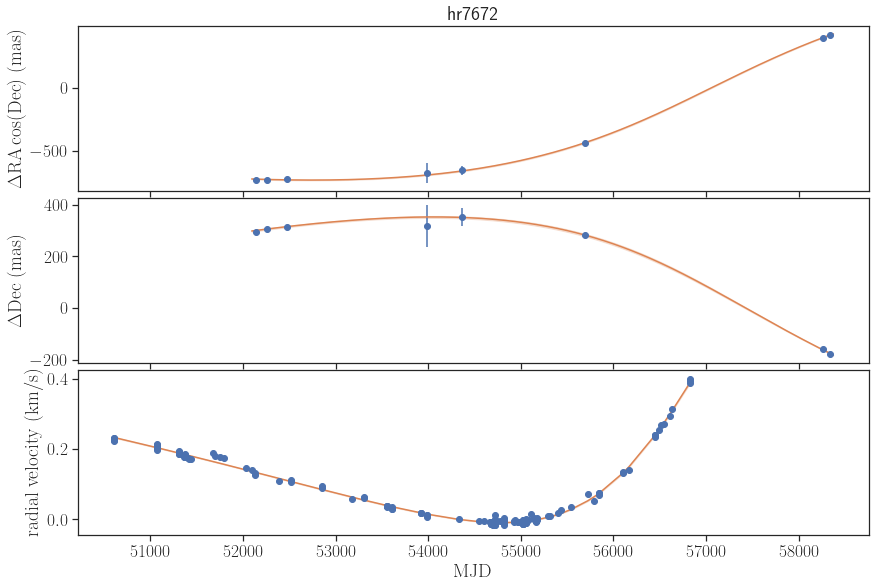

In [48]:
fig, ax = plt.subplots(3,1,sharex=True, figsize=(12,8))
ax[0].set_title(targname)
ax[0].errorbar(mjd, xobs, fmt='o', yerr=xyerr)
ax[0].plot(tdense, xdmean, '-', color='C1')
ax[0].fill_between(tdense, xdmean-xdstd, xdmean+xdstd, color='C1', alpha=0.2)
ax[0].set_ylabel("$\Delta\mathrm{RA}\cos(\mathrm{Dec})$ $(\mathrm{mas})$")
ax[1].set_ylabel("$\Delta\mathrm{Dec}$ $(\mathrm{mas})$")
ax[1].errorbar(mjd, yobs, fmt='o', yerr=xyerr, color='C0')
ax[1].plot(tdense, ydmean, '-', color='C1')
ax[1].fill_between(tdense, ydmean-ydstd, ydmean+ydstd, color='C1', alpha=0.2)
ax[2].set_ylabel("$\mathrm{radial\ velocity\ (km/s)}$")
ax[2].set_xlabel("$\mathrm{MJD}$")
ax[2].errorbar(mjdrv, rv, fmt='o', yerr=rverr)
ax[2].plot(mjdrv, rvmean, '-', color='C1')
ax[2].fill_between(mjdrv, rvmean - rvstd, rvmean + rvstd, color='C1', alpha=0.2)
fig.tight_layout(pad=0.1)
plt.savefig(basename+"_models.png", dpi=200, bbox_inches="tight")

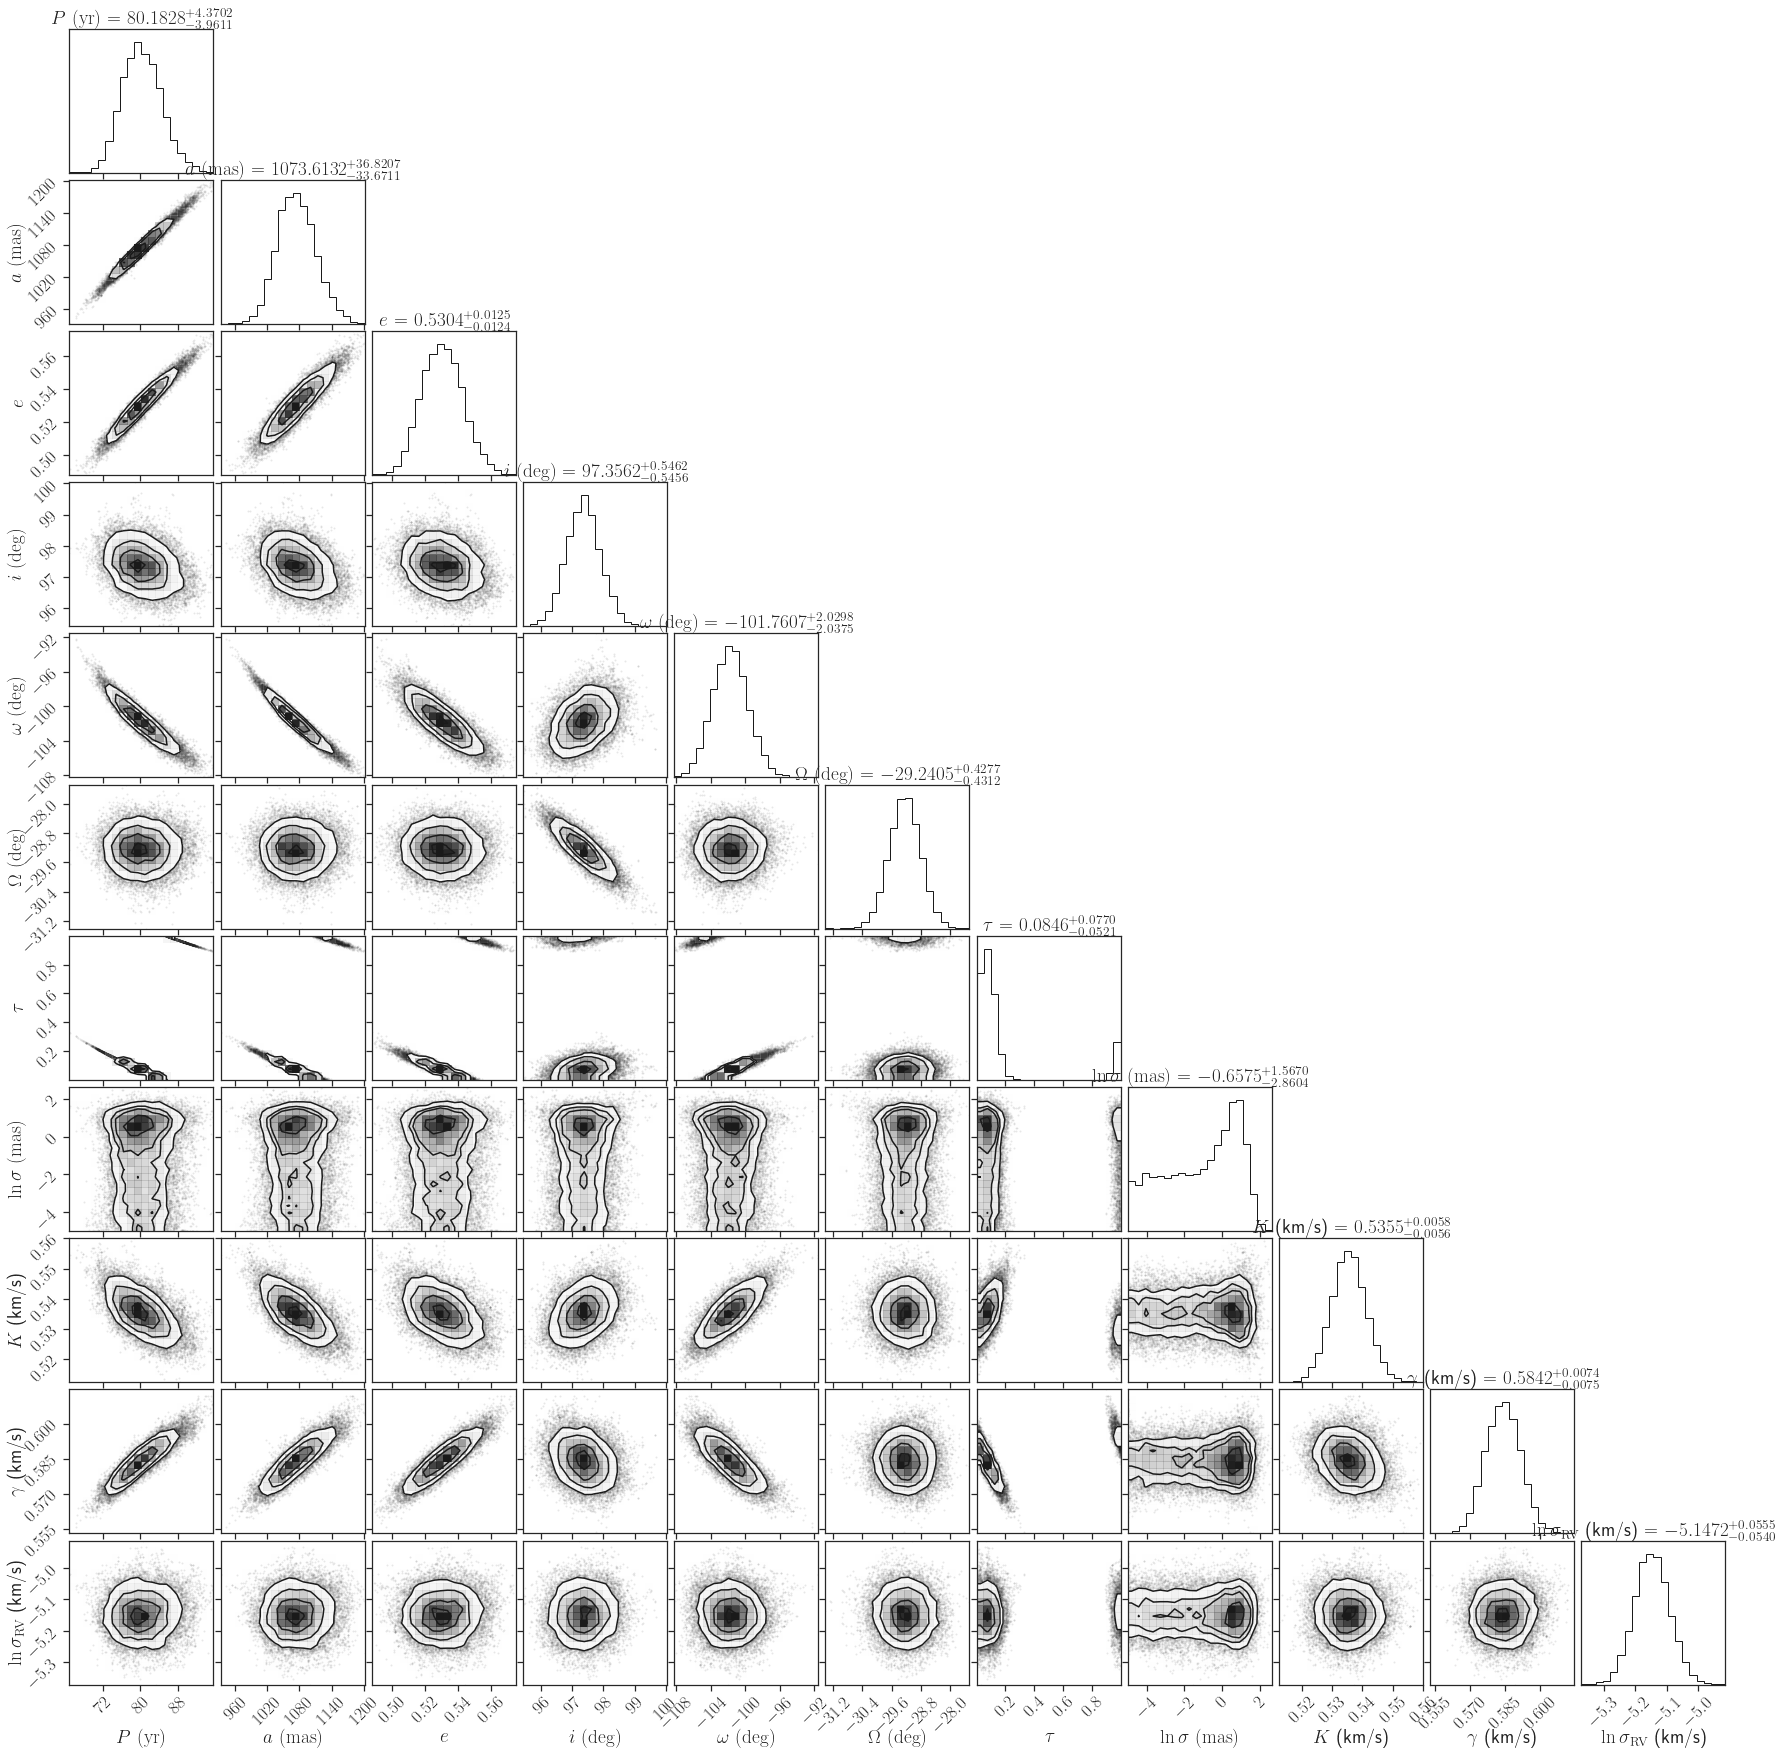

In [49]:
hyper = pd.DataFrame(data=dict(zip(keys, [mcmc.get_samples()[k] for k in keys])))
fig = corner.corner(hyper, labels=labels, show_titles=True, title_fmt='.4f')
fig.savefig(basename+"_corner.png", dpi=200, bbox_inches="tight")

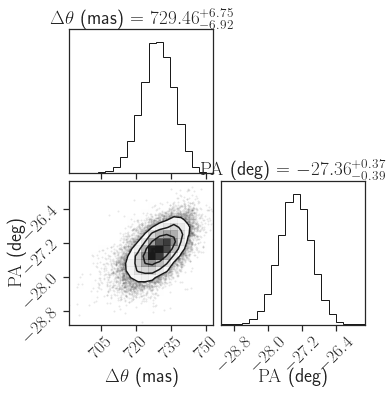

In [50]:
fig = corner.corner(np.array([s['seppred'], s['papred']]).T, labels=[r'$\Delta\theta$ (mas)', '$\mathrm{PA}$ (deg)'], show_titles=True, title_fmt='.2f')
fig.savefig(basename+"_prediction.png", dpi=200, bbox_inches="tight")